[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/flax/blob/main/docs/mnist_tutorial.ipynb)
[![Open On GitHub](https://img.shields.io/badge/Open-on%20GitHub-blue?logo=GitHub)](https://github.com/google/flax/blob/main/docs/mnist_tutorial.ipynb)

# MNIST Tutorial

Welcome to NNX! This tutorial will guide you through building and training a simple convolutional 
neural network (CNN) on the MNIST dataset using the NNX API. NNX is a Python neural network library
built upon [JAX](https://github.com/google/jax) and currently offered as an experimental module within 
[Flax](https://github.com/google/flax).

## 1. Install NNX

Since NNX is under active development, we recommend using the latest version from the Flax GitHub repository:

In [1]:
# !pip install git+https://github.com/google/flax.git

## 2. Load the MNIST Dataset

First, the MNIST dataset is loaded and prepared for training and testing using 
Tensorflow Datasets. Image values are normalized, the data is shuffled and divided 
into batches, and samples are prefetched to enhance performance.

In [2]:
import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf  # TensorFlow operations

tf.random.set_seed(0)  # set random seed for reproducibility

num_epochs = 10
batch_size = 32

train_ds: tf.data.Dataset = tfds.load('mnist', split='train')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

train_ds = train_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # normalize train set
test_ds = test_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # normalize test set

# create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
train_ds = train_ds.repeat(num_epochs).shuffle(1024)
# group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)
# create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
test_ds = test_ds.shuffle(1024)
# group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

/Users/cgarciae/repos/flax/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Define the Network with NNX

Create a convolutional neural network with NNX by subclassing `nnx.Module`.

In [3]:
from flax.experimental import nnx  # NNX API
from functools import partial

class CNN(nnx.Module):
  """A simple CNN model."""

  def __init__(self, *, rngs: nnx.Rngs):
    self.conv1 = nnx.Conv(1, 32, kernel_size=(3, 3), rngs=rngs)
    self.conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), rngs=rngs)
    self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
    self.linear1 = nnx.Linear(3136, 256, rngs=rngs)
    self.linear2 = nnx.Linear(256, 10, rngs=rngs)

  def __call__(self, x):
    x = self.avg_pool(nnx.relu(self.conv1(x)))
    x = self.avg_pool(nnx.relu(self.conv2(x)))
    x = x.reshape(x.shape[0], -1)  # flatten
    x = nnx.relu(self.linear1(x))
    x = self.linear2(x)
    return x

model = CNN(rngs=nnx.Rngs(0))
nnx.display(model)

### Run model

Let's put our model to the test!  We'll perform a forward pass with arbitrary data and print the results.

In [4]:
import jax.numpy as jnp  # JAX NumPy

y = model(jnp.ones((1, 28, 28, 1)))
nnx.display(y)

## 4. Create Optimizer and Metrics

In NNX, we create an `Optimizer` object to manage the model's parameters and apply gradients during training. `Optimizer` receives the model parameters and an `optax` optimizer that will define the update rules. Additionally, we'll define a `MultiMetric` object to keep track of the `Accuracy` and the `Average` loss.

In [5]:
import optax

learning_rate = 0.005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(), 
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)

## 5. Training step

We define a loss function using cross entropy loss (see more details in [`optax.softmax_cross_entropy_with_integer_labels()`](https://optax.readthedocs.io/en/latest/api/losses.html#optax.softmax_cross_entropy_with_integer_labels)) that our model will optimize over. In addition to the loss, the logits are also outputted since they will be used to calculate the accuracy metric during training and testing.

In [6]:
def loss_fn(model: CNN, batch):
  logits = model(batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
  ).mean()
  return loss, logits

Next, we create the training step function. This function takes the `model` and a data `batch` and does the following:

* Computes the loss, logits and gradients with respect to the loss function using `nnx.value_and_grad`.
* Updates training accuracy using the loss, logits, and batch labels.
* Updates model parameters via the optimizer by applying the gradient updates.

In [7]:
@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])
  optimizer.update(grads)

The [`nnx.jit`](https://flax.readthedocs.io/en/latest/api_reference/flax.experimental.nnx/transforms.html#flax.experimental.nnx.jit) decorator traces the `train_step` function for just-in-time compilation with 
[XLA](https://www.tensorflow.org/xla), optimizing performance on 
hardware accelerators. `nnx.jit` is similar to [`jax.jit`](https://jax.readthedocs.io/en/latest/_autosummary/jax.jit.html#jax.jit),
except it can transforms functions that contain NNX objects as inputs and outputs.

## 6. Evaluation step

Create a separate function to calculate loss and accuracy metrics for the test batch, since this will be outside the `train_step` function. Loss is determined using the `optax.softmax_cross_entropy_with_integer_labels` function, since we're reusing the loss function defined earlier.

In [8]:
@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])

## 7. Seed randomness

For reproducible dataset shuffling (using `tf.data.Dataset.shuffle`), set the TF random seed.

In [9]:
tf.random.set_seed(0)

## 8. Train and Evaluate

Now we train a model using batches of data for 10 epochs, evaluate its performance 
on the test set after each epoch, and log the training and testing metrics (loss and
accuracy) throughout the process. Typically this leads to a model with around 99% accuracy.

In [10]:
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs

metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - the train state's model parameters
  # - the optimizer state
  # - the training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)

  if (step + 1) % num_steps_per_epoch == 0:  # one training epoch has passed
    # Log training metrics
    for metric, value in metrics.compute().items():  # compute metrics
      metrics_history[f'train_{metric}'].append(value)  # record metrics
    metrics.reset()  # reset metrics for test set

    # Compute metrics on the test set after each training epoch
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log test metrics
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # reset metrics for next training epoch

    print(
      f"train epoch: {(step+1) // num_steps_per_epoch}, "
      f"loss: {metrics_history['train_loss'][-1]}, "
      f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
    )
    print(
      f"test epoch: {(step+1) // num_steps_per_epoch}, "
      f"loss: {metrics_history['test_loss'][-1]}, "
      f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
    )

2024-04-25 15:11:51.147408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train epoch: 1, loss: 0.10209392756223679, accuracy: 96.92666625976562
test epoch: 1, loss: 0.05703972652554512, accuracy: 98.10697174072266


2024-04-25 15:12:16.589051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train epoch: 2, loss: 0.04372011497616768, accuracy: 98.63666534423828
test epoch: 2, loss: 0.041248343884944916, accuracy: 98.73797607421875


2024-04-25 15:12:41.074941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train epoch: 3, loss: 0.030999813228845596, accuracy: 99.0433349609375
test epoch: 3, loss: 0.05681844428181648, accuracy: 98.49759674072266


2024-04-25 15:13:06.820973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train epoch: 4, loss: 0.026122156530618668, accuracy: 99.25333404541016
test epoch: 4, loss: 0.04033380746841431, accuracy: 98.68789672851562


2024-04-25 15:13:32.306590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train epoch: 5, loss: 0.023744497448205948, accuracy: 99.31500244140625
test epoch: 5, loss: 0.05083772540092468, accuracy: 98.76802825927734


2024-04-25 15:13:57.767435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train epoch: 6, loss: 0.01850314810872078, accuracy: 99.45500183105469
test epoch: 6, loss: 0.04953562840819359, accuracy: 98.85816955566406


2024-04-25 15:14:23.140815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train epoch: 7, loss: 0.015862680971622467, accuracy: 99.51166534423828
test epoch: 7, loss: 0.0707646906375885, accuracy: 98.40745544433594


2024-04-25 15:14:49.081003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train epoch: 8, loss: 0.018966104835271835, accuracy: 99.47333526611328
test epoch: 8, loss: 0.061334095895290375, accuracy: 98.89823913574219


2024-04-25 15:15:14.341633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train epoch: 9, loss: 0.015244723297655582, accuracy: 99.6050033569336
test epoch: 9, loss: 0.07078084349632263, accuracy: 98.78805541992188
train epoch: 10, loss: 0.013812240213155746, accuracy: 99.61500549316406
test epoch: 10, loss: 0.09043453633785248, accuracy: 98.818115234375


2024-04-25 15:15:39.885448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-25 15:15:39.886727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 9. Visualize Metrics

Use Matplotlib to create plots for loss and accuracy.

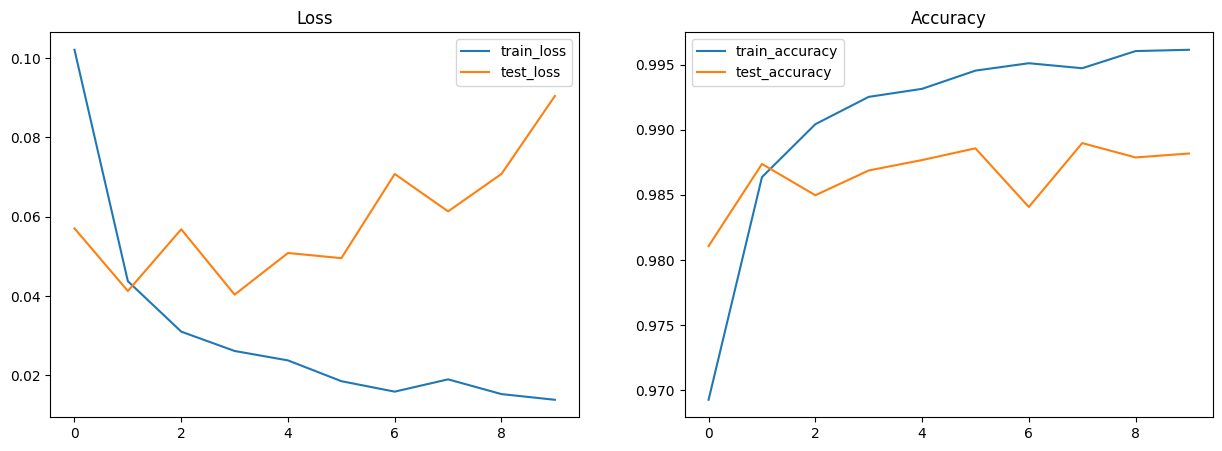

In [11]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

## 10. Perform inference on test set

Define a jitted inference function, `pred_step`, to generate predictions on the test set using the learned model parameters. This will enable you to visualize test images alongside their predicted labels for a qualitative assessment of model performance.

In [12]:
@nnx.jit
def pred_step(model: CNN, batch):
  logits = model(batch['image'])
  return logits.argmax(axis=1)

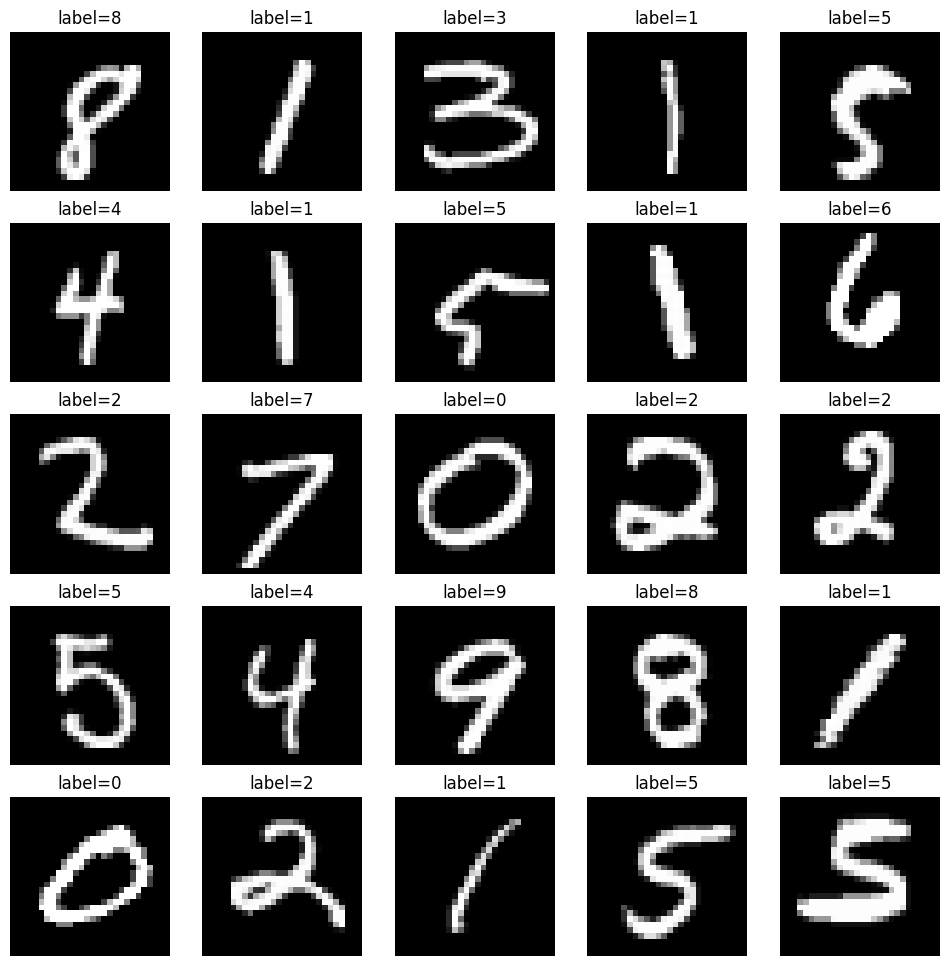

In [13]:
test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(model, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
  ax.set_title(f'label={pred[i]}')
  ax.axis('off')

Congratulations! You made it to the end of the annotated MNIST example.